# Destaggering U and V wind components

## Introduction and aims
* Atmospheric models are often run on a "staggered" grid for computational stability. That is, some model variables are offset by half a grid length relative to other variables.
* This includes the ACCESS model and AUS2200. In the case of AUS2200, U and V wind components have been saved on their staggered grids, and therefore need to be de-staggered prior to analysis.
* This notebook demonstrates three methods for destaggering U and V wind components from AUS2200 data, and visualises the output with a quiver plot.

In [1]:
#Assumes access to hh5 conda environment

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from dask.distributed import Client
from xgcm import Grid

In [2]:
#Start a distributed dask client. You can click "Launch dashboard in JupyterLab" in the cell output to see progress

client = Client()
client

2024-12-19 14:50:16,870 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-12-19 14:50:16,875 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-12-19 14:50:16,879 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0062.gadi.nci.org.au/44208/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0062.gadi.nci.org.au/44208/proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45709,Workers: 14
Dashboard: /node/gadi-cpu-bdw-0062.gadi.nci.org.au/44208/proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44347,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0062.gadi.nci.org.au/44208/proxy/35625/status,Memory: 0 B
Nanny: tcp://127.0.0.1:44399,


In [3]:
#Load an AUS2200 experiment directly from the ua8 file path, for a single time

uas_path = "/g/data/ua8/AUS2200/ecoastlow-evolvsst/v1-0/1hr/uas/uas_AUS2200_ecoastlow-evolsst_1hr_201606030030-201606072330.nc"
vas_path = "/g/data/ua8/AUS2200/ecoastlow-evolvsst/v1-0/1hr/vas/vas_AUS2200_ecoastlow-evolsst_1hr_201606030030-201606072330.nc"
uas = xr.open_dataset(uas_path,chunks={}).sel(time='2016-06-05 18:00',method="nearest").squeeze()
vas = xr.open_dataset(vas_path,chunks={}).sel(time='2016-06-05 18:00',method="nearest").squeeze()

In [4]:
print("Experiment description: \n")
print(uas.attrs["exp_description"])

Experiment description: 

A limited area model study of the entire Australian continent at 2.2 km resolution, using the UM atmospheric model. ERA5+ERA5Land reanalysis data was used to provide initial and boundary conditions, sea-surface temperatures are evolving throughout the simulation. The study covers the period from 2016-06-03 to 2016-06-07, including the East Coast Low event which gave rise to widespread flooding in many areas stretching from southeast Queensland, eastern New South Wales, eastern Victoria, and large areas of northern Tasmania.


**You can see more information on this runs, including how to cite it, [here](https://dx.doi.org/10.25914/vkk9-4m12)**

## Chunking

We have loaded in in 10-metre u and v wind data, with 4 chunks in the lat and lon directions. We will return to this later when we consider different destaggering methods

In [5]:
uas.uas

<xarray.DataArray 'uas' (lat: 2120, lon: 2600)> Size: 22MB
dask.array<getitem, shape=(2120, 2600), dtype=float32, chunksize=(1060, 1300), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 2016-06-05T18:30:00.000000256
  * lat      (lat) float64 17kB -48.79 -48.77 -48.75 ... -6.871 -6.852 -6.832
  * lon      (lon) float64 21kB 114.3 114.3 114.3 114.3 ... 165.7 165.7 165.7
    height   float64 8B ...
Attributes:
    standard_name:          eastward_wind
    long_name:              Eastward Near-Surface Wind
    comment:                Eastward component of the near-surface (usually, ...
    units:                  m s-1
    cell_methods:           area: mean time: mean
    cell_measures:          area: areacella
    history:                2024-10-16T01:32:52Z altered by CMOR: Treated sca...
    coverage_content_type:  modelResult

## Staggered grid

The AUS2200 u wind data has been saved on a staggered longitude grid, while the v wind data has been saved on a staggered latitude grid. See how the longitude coordinates are different (and offset by 0.5 * grid spacing). If we were to combine u and v now into one dataset using something like `xr.Dataset({"u":uas.uas,"v":vas:vas})`, then xarray would do it by meshing together the grids with missing values (this is not what we want to do).

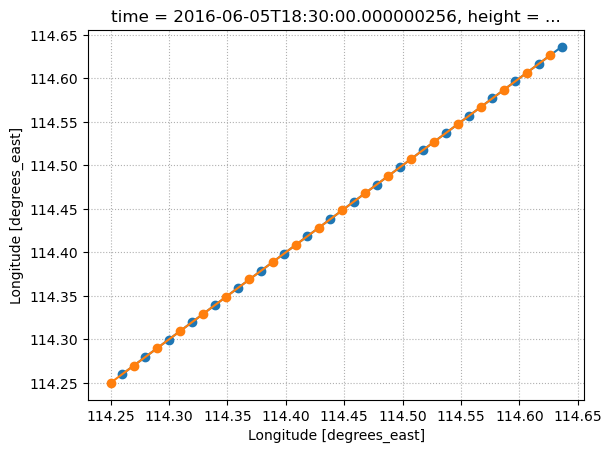

In [6]:
vas.lon.isel(lon=slice(0,20)).plot(marker="o")
uas.lon.isel(lon=slice(0,20)).plot(marker="o")
plt.gca().grid(ls=":")

The staggered grid has also resulted in one extra latitude grid point, so the vas variable is on a different size grid

In [7]:
uas.uas.shape

(2120, 2600)

In [8]:
vas.vas.shape

(2121, 2600)

## Destaggering (centring)

If we want to perform any analysis or make plots, we need u and v to be on the same grid. Our first method will be to centre u in longitude and v in latitude by averaging

In [9]:
#Set up the destaggered coordinates. 
#Note that our centring approach will result in one less grid point, so we need to slice the lons down accordingly
#The latitude for v is already one grid point longer than u, so we don't need to do this for latitude

destaggered_lon_coord = vas.lon.isel({"lon":slice(0,-1)})
destaggered_lat_coord = uas.lat

In [10]:
#Now we can slice and centre/average the U data in longitude.
#We need to manually reassign the longitude coordinates using assign_coords()
uas_destaggered = ((uas.uas.isel({"lon":slice(0,-1)}).assign_coords({"lon":destaggered_lon_coord}) +\
      uas.uas.isel({"lon":slice(1,uas.lon.shape[0])}).assign_coords({"lon":destaggered_lon_coord})) / 2)

In [11]:
#Same for V
vas_destaggered = ((vas.vas.isel({"lat":slice(0,-1)}).assign_coords({"lat":destaggered_lat_coord}) +\
      vas.vas.isel({"lat":slice(1,vas.lat.shape[0])}).assign_coords({"lat":destaggered_lat_coord})) / 2)

## Combining 
Now we can safely combine the u and v wind components into one dataset (useful for plotting later), and calculate wind speed.

**Note that our data is still chunked, although an extra two small chunks have been added due to the different grid sizes**

In [12]:
destaggered_ds = xr.Dataset({"u":uas_destaggered,"v":vas_destaggered})
destaggered_ds["wind_speed"] = np.sqrt( destaggered_ds["u"]**2 + destaggered_ds["v"]**2 )

In [13]:
print("Chunk sizes: ",destaggered_ds["u"].chunksizes)
destaggered_ds["u"]

Chunk sizes:  Frozen({'lat': (1060, 1060), 'lon': (1299, 1, 1300)})


<xarray.DataArray 'u' (lat: 2120, lon: 2600)> Size: 22MB
dask.array<where, shape=(2120, 2600), dtype=float32, chunksize=(1060, 1300), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 17kB -48.79 -48.77 -48.75 ... -6.871 -6.852 -6.832
  * lon      (lon) float64 21kB 114.3 114.3 114.3 114.3 ... 165.7 165.7 165.7
    time     datetime64[ns] 8B 2016-06-05T18:30:00.000000256
    height   float64 8B 10.0

## Destaggering (interp)

It would be a little neater to just use xr.interp to destagger, which is demonstrated below. But note that our **chunking is not preserved in this method**, because dask needs to access the whole lat/lon dimension to do the spatial interpolation. So we now have only one chunk in longitude for the U variable. This could impact memory usage if you need to destagger really large data (not an issue here for one time step, and surface level data only)

In [14]:
uas_destaggered_interp = uas.uas.interp({"lon":destaggered_lon_coord},method="linear")
vas_destaggered_interp = vas.vas.interp({"lat":destaggered_lat_coord},method="linear")
destaggered_ds_interp = xr.Dataset({"u":uas_destaggered_interp,"v":vas_destaggered_interp})
destaggered_ds_interp["wind_speed"] = np.sqrt( destaggered_ds_interp["u"]**2 + destaggered_ds_interp["v"]**2 )
destaggered_ds_interp["u"]

<xarray.DataArray 'u' (lat: 2120, lon: 2600)> Size: 22MB
dask.array<where, shape=(2120, 2600), dtype=float32, chunksize=(1060, 2600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 17kB -48.79 -48.77 -48.75 ... -6.871 -6.852 -6.832
  * lon      (lon) float64 21kB 114.3 114.3 114.3 114.3 ... 165.7 165.7 165.7
    time     datetime64[ns] 8B 2016-06-05T18:30:00.000000256
    height   float64 8B 10.0
Attributes:
    standard_name:          eastward_wind
    long_name:              Eastward Near-Surface Wind
    comment:                Eastward component of the near-surface (usually, ...
    units:                  m s-1
    cell_methods:           area: mean time: mean
    cell_measures:          area: areacella
    history:                2024-10-16T01:32:52Z altered by CMOR: Treated sca...
    coverage_content_type:  modelResult

## xgcm

There is also the xgcm package [that is designed to handle staggered grids](https://xgcm.readthedocs.io/en/latest/grids.html). Here, we first need to rename the staggered lat and lon coordinates

In [15]:
uas_renamed = uas.rename({"lon":"lon_stag"})
vas_renamed = vas.rename({"lat":"lat_stag"}).isel({"lat_stag":slice(0,-1)})

wind_ds = xr.Dataset({"u":uas_renamed.uas, "v":vas_renamed.vas})
wind_ds

<xarray.Dataset> Size: 44MB
Dimensions:   (lat: 2120, lon_stag: 2600, lat_stag: 2120, lon: 2600)
Coordinates:
    time      datetime64[ns] 8B 2016-06-05T18:30:00.000000256
  * lat       (lat) float64 17kB -48.79 -48.77 -48.75 ... -6.871 -6.852 -6.832
  * lon_stag  (lon_stag) float64 21kB 114.3 114.3 114.3 ... 165.7 165.7 165.7
    height    float64 8B 10.0
  * lat_stag  (lat_stag) float64 17kB -48.8 -48.78 -48.76 ... -6.861 -6.842
  * lon       (lon) float64 21kB 114.3 114.3 114.3 114.3 ... 165.7 165.7 165.7
Data variables:
    u         (lat, lon_stag) float32 22MB dask.array<chunksize=(1060, 1300), meta=np.ndarray>
    v         (lat_stag, lon) float32 22MB dask.array<chunksize=(1061, 1300), meta=np.ndarray>

As previously, we can see that u and v are different coordinates. We can now create an xgcm Grid object, by indicating which coordinates are staggered and which are "centred" ([following the xgcm definitions](https://xgcm.readthedocs.io/en/latest/grids.html#axes-and-positions))

In [16]:
grid = Grid(wind_ds,
            coords={ "lon":{"center":"lon", "left":"lon_stag"}, "lat":{"center":"lat", "left":"lat_stag"} },
            periodic=False,
           )

Similar to the xarray interp method, xgcm can now interpolate the grid for us, so the u and v wind components are on the "centred" coordinates. Xgcm can be very useful for [computing differences on a staggered grids](https://cosima-recipes.readthedocs.io/en/latest/Recipes/Relative_Vorticity.html#Method-3:-Using-xgcm-to-replicate-MOM5's-calculation-for-vorticity_z)

In [17]:
uas_destaggered_xgcm = grid.interp(wind_ds.u,"lon")
vas_destaggered_xgcm = grid.interp(wind_ds.v,"lat")
destaggered_ds_xgcm = xr.Dataset({"u":uas_destaggered_xgcm,"v":vas_destaggered_xgcm})
destaggered_ds_xgcm["wind_speed"] = np.sqrt( destaggered_ds_xgcm["u"]**2 + destaggered_ds_xgcm["v"]**2 )

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


**Note** that as in the xarray method, our chunking has changed in the direction of the staggered coordinate

In [18]:
destaggered_ds_interp["u"]

<xarray.DataArray 'u' (lat: 2120, lon: 2600)> Size: 22MB
dask.array<where, shape=(2120, 2600), dtype=float32, chunksize=(1060, 2600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 17kB -48.79 -48.77 -48.75 ... -6.871 -6.852 -6.832
  * lon      (lon) float64 21kB 114.3 114.3 114.3 114.3 ... 165.7 165.7 165.7
    time     datetime64[ns] 8B 2016-06-05T18:30:00.000000256
    height   float64 8B 10.0
Attributes:
    standard_name:          eastward_wind
    long_name:              Eastward Near-Surface Wind
    comment:                Eastward component of the near-surface (usually, ...
    units:                  m s-1
    cell_methods:           area: mean time: mean
    cell_measures:          area: areacella
    history:                2024-10-16T01:32:52Z altered by CMOR: Treated sca...
    coverage_content_type:  modelResult

## Plotting

Visualise the winds using a quiver plot and contour the wind speed. Both methods of destaggering produce the same outcome

Text(0.5, 1.0, 'xgcm interp')

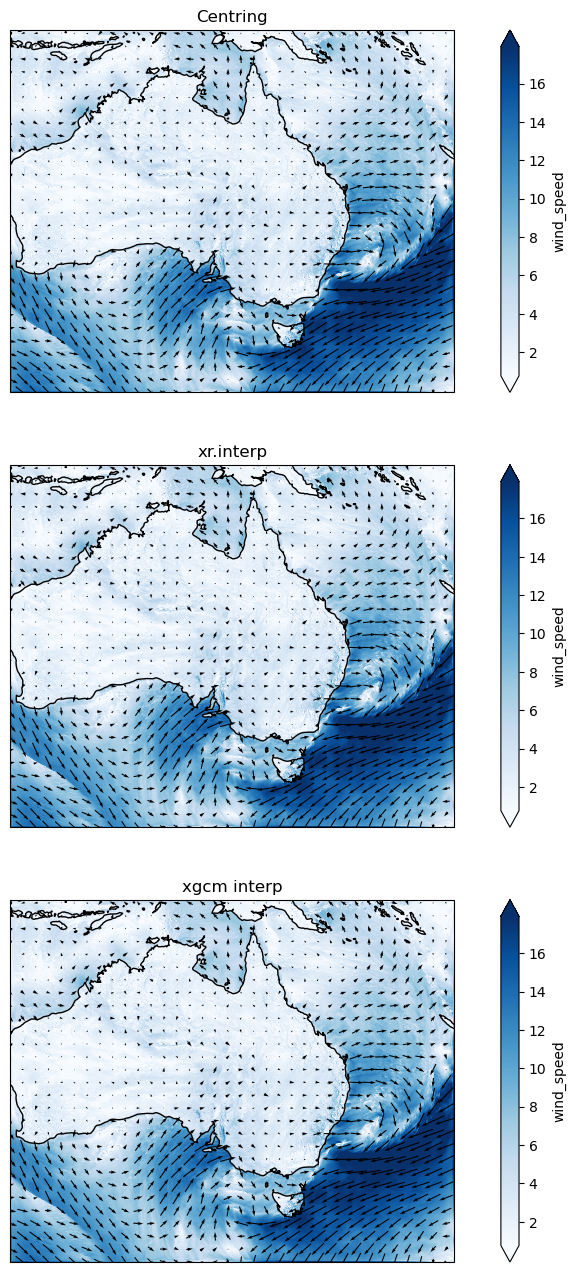

In [19]:
#Set the spacing of the wind vectors in lat and lon
step = 75

plt.figure(figsize=[12,16])
ax = plt.subplot(3,1,1,projection=ccrs.PlateCarree())
destaggered_ds["wind_speed"].plot(robust=True,cmap="Blues")
destaggered_ds.isel({"lat":slice(0,-1,step),"lon":slice(0,-1,step)}).plot.quiver(
    "lon","lat","u","v")
ax.coastlines()
plt.title("Centring")

ax = plt.subplot(3,1,2,projection=ccrs.PlateCarree())
destaggered_ds_interp["wind_speed"].plot(robust=True,cmap="Blues")
destaggered_ds_interp.isel({"lat":slice(0,-1,step),"lon":slice(0,-1,step)}).plot.quiver(
    "lon","lat","u","v")
ax.coastlines()
plt.title("xr.interp")

ax = plt.subplot(3,1,3,projection=ccrs.PlateCarree())
destaggered_ds_xgcm["wind_speed"].plot(robust=True,cmap="Blues")
destaggered_ds_xgcm.isel({"lat":slice(0,-1,step),"lon":slice(0,-1,step)}).plot.quiver(
    "lon","lat","u","v")
ax.coastlines()
plt.title("xgcm interp")

#### Contributors

* **Andrew Brown**

    ARC Centre of Excellence for 21st Century Weather, University of Melbourne
    
If you have any enquries, suggested improvements or bug reports related to this recipe, please [open an issue](https://github.com/ACCESS-Community-Hub/atmosphere-cookbook/issues/new?template=Blank+issue) or [start a discussion](https://github.com/ACCESS-Community-Hub/atmosphere-cookbook/discussions/new/choose) in this repository.